In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from joblib import Parallel

from useful_func import *


from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from scipy.ndimage import binary_erosion


import tifffile as tiff
from tqdm import tqdm

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

import click

from alienlab.plot import PlotFigure
p = PlotFigure()
p.save_folder = "G:/DREAM/from_github/thesis/Intensity_paper/"
p.extension = ".pdf"

#%matplotlib widget

In [14]:
file_default = "../data/diaphragme/video_liq_full.tiff"

file = click.prompt("Enter the file or folder path", type=str, default=file_default)

if os.path.isfile(file):
    video = tiff.imread(file)
    
elif os.path.isdir(file):
    video = []
    for im in tqdm(glob.glob(file + "/*.tiff")):
        video.append(tiff.imread(im))
    video = np.array(video)
    
else:
    print('wrong path')
    
    


Enter the file or folder path [../data/diaphragme/video_liq_full.tiff]:

In [15]:
framerate = click.prompt("Camera framerate", type=int, default=3)
timing = np.linspace(0, len(video)-1, len(video))/framerate

Camera framerate [3]:

  5


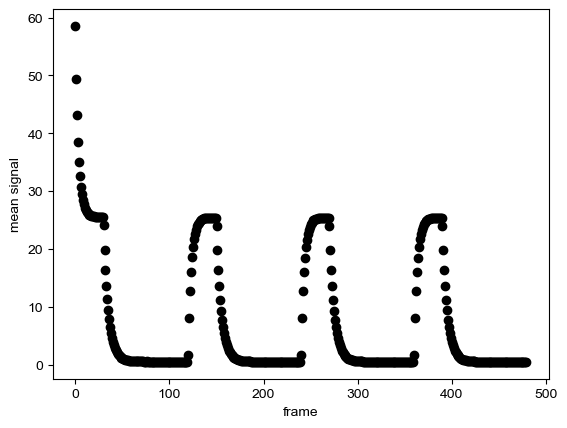

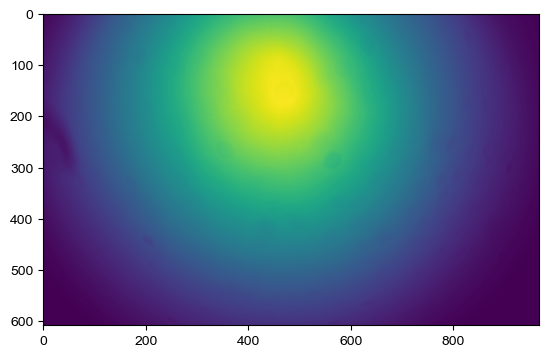

In [16]:
plt.xlabel('frame')
plt.ylabel('mean signal')
plt.plot(np.mean(video[0:], axis = (1,2)), "ko")
plt.figure()

slices = np.mean(video, axis = (1,2))
frames = video[slices>np.quantile(slices, 0.8)]
frame_ref = np.mean(frames, axis =0)
plt.imshow(frame_ref)

In [17]:
D = click.prompt("smoothing & downscaling factor to accelerate computations", type=int, default=5)
D_image = downscale_local_mean(frame_ref, (D,D))

#downscaling 
video_downscaled = []
for i in range(0, video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]


smoothing & downscaling factor to accelerate computations [5]:

  3


skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


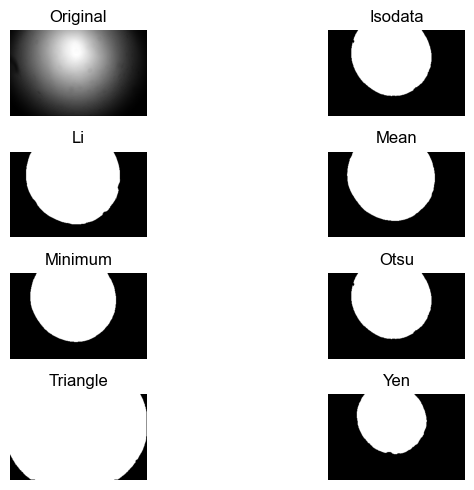

In [18]:
u = skimage.filters.try_all_threshold(D_image)


copy the name of the thresholding method that suits you. If none suits, enter None [skimage.filters.thresholding.threshold_minimum]:

  skimage.filters.thresholding.threshold_triangle


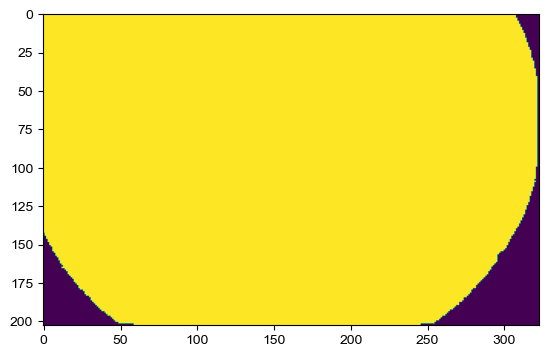

In [19]:
threshold_method = threshold_convert(click.prompt("copy the name of the thresholding method that suits you. If none suits, enter None", type = str, default="skimage.filters.thresholding.threshold_minimum"))

video = np.array(video)
timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
threshold = threshold_method(D_image)

mask = D_image>threshold
plt.imshow(mask)



Text(0, 0.5, 'fluorescence')

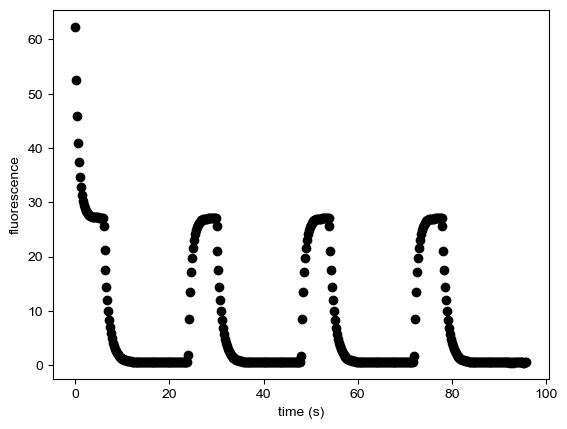

In [20]:
video_2D = np.copy(video_downscaled)
video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

to_evaluate = video_downscaled[:,mask.flatten()]

plt.plot(timing, np.mean(to_evaluate, axis = 1), 'ok')
plt.xlabel('time (s)')
plt.ylabel('fluorescence')

First useful frame [0]:

  269


Last useful frame [0]:

  340


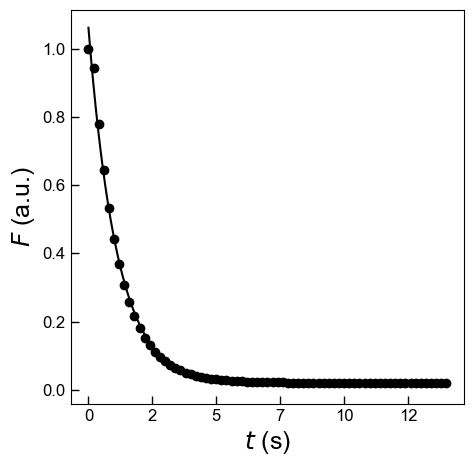

In [21]:
start = click.prompt("First useful frame", type=int, default=0)
stop = click.prompt("Last useful frame", type=int, default=0)





fig = p.set_figure("%d", "%0.1f")
time = timing[start:stop]
time -= time[0]
y = np.mean(to_evaluate[start:stop], axis = 1)
y /= y[0]
#fit on the mean value before performing the fit on each pixel
params = simple_tau(y, timing[start:stop], sample_rate = framerate)


plt.plot(time, y, "ok", label = "raw data")
x2 = np.linspace(time.min(), time.max(), 1024)
plt.plot(x2, exp_decay(params, x2), "k", label = "fit")

plt.xlabel('$t$ (s)')
plt.ylabel("$F$ (a.u.)")
#plt.legend()
plt.savefig(p.save_folder + "epi_mean_decay_fit_D2.pdf")

In [22]:
sat = np.sum(to_evaluate[0]==255)/len(to_evaluate[0].flatten())*100
print("percent of saturated pixels in the mask: ", sat)

if sat > 2:
    print("WARNING, more than 2% of the pixels are saturated on the first frame, try acquiring the movie with shorter exposure/smaller gain.")

percent of saturated pixels in the mask:  0.0


In [23]:
#parallel fit on each pixel of the mask
tau_lists = Parallel(n_jobs = -1 )(parallel_tau(to_evaluate[start:stop,i], timing[start:stop], sample_rate = framerate) for i in tqdm(range(to_evaluate.shape[1])))


100%|██████████████████████████████████████████████████████████████████████████| 61288/61288 [00:21<00:00, 2884.18it/s]


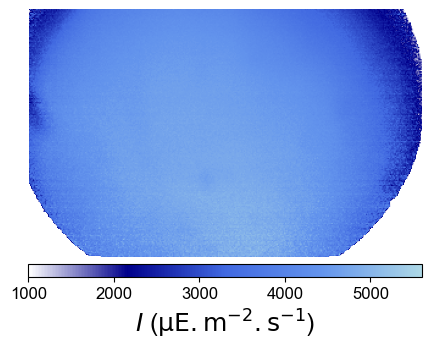

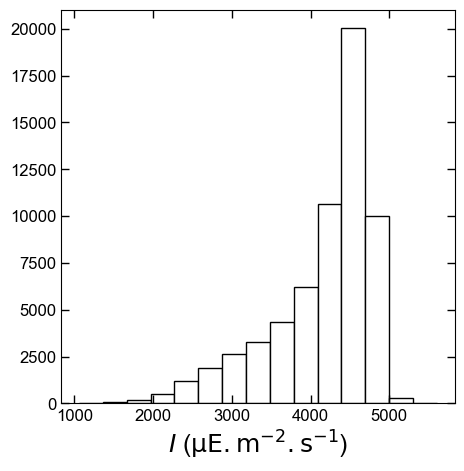

In [24]:
tau_480 = np.array(tau_lists)
tau_480_map = np.zeros(mask.shape)
tau_480_map[mask] = tau_480


I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480

np.save("../images/I_480_map.npy", I_480_map)

plt.rcParams['image.cmap'] = 'viridis'


 
I, dis, fig = plot_map(I_480, I_480_map,"test_app" + "_I_480_map_B" + p.extension, limits = (1000, 7000))

np.save("../images/video_2D.npy", video_2D[start:stop])
np.save("../images/framerate.npy", framerate)


C:\Users\Alienor\AppData\Local\Temp\ipykernel_26260\2531773703.py:1: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(np.log(I_480_map[303:325, 460:490]))
C:\Users\Alienor\AppData\Local\Temp\ipykernel_26260\2531773703.py:1: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(np.log(I_480_map[303:325, 460:490]))


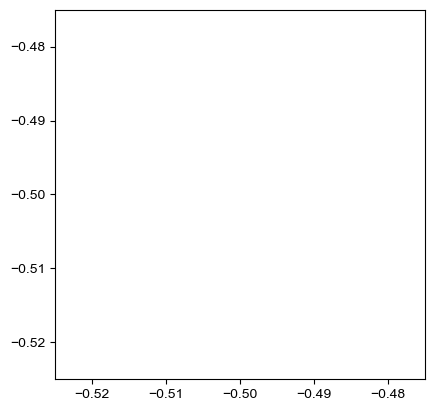

In [13]:
plt.imshow(np.log(I_480_map[303:325, 460:490]))

(array([419.,   0.,   5.,  39.,  99.,  67.,  20.,   7.,   3.,   1.]),
 array([   0.        ,  748.35984719, 1496.71969438, 2245.07954157,
        2993.43938875, 3741.79923594, 4490.15908313, 5238.51893032,
        5986.87877751, 6735.2386247 , 7483.59847188]),
 <BarContainer object of 10 artists>)

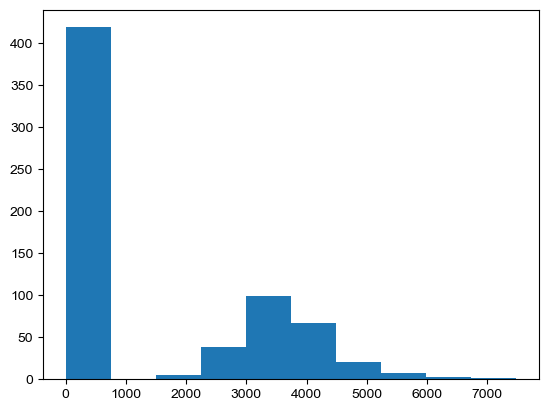

In [40]:
plt.hist((I_480_map[303:325, 460:490]).flatten())